# Carregando dataset

In [17]:
import os
import numpy as np
import pydicom
from tqdm import tqdm # Ver processo do loop
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import pickle
from keras.preprocessing.image import ImageDataGenerator
import random
from keras import backend as K
from sklearn.model_selection import train_test_split
import shutil

seed = 42
np.random.seed(seed)

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

DATASET_PATH = 'Sunnybrook_Dataset/SCD_DeidentifiedImages/'
CONTOUR_PATH = 'Sunnybrook_Dataset/SCD_ManualContours/'
# PICKLE_PATH = 'Sunnybrook_Dataset/pickled_data/'
PICKLE_PATH = 'pickle/'
AUGMENTATION_PATH = 'Sunnybrook_Dataset/Data_Augmentation/'
MODEL_PATH = 'modelo/Attention_da'

In [18]:
def converter_pixel_array_rgb(dicom):
    dicom_rgb = np.empty((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=dicom.dtype)
    dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
    dicom_rgb = dicom_rgb / np.max(dicom_rgb)
    return dicom_rgb

def converter_mascara_binario(mask):
    im_bw = mask[:,:,0]
    im_bw = im_bw[:,:,np.newaxis]
    return im_bw

In [19]:
###### ATUALIZAR BASE DA DADOS APOS DATA AUGMENTATION
def atualiza_bd(conjunto, path, tipo_conjunto):
    AUG_PATH = path + '/'
#     AUG_PATH = AUGMENTATION_PATH + tipo_conjunto + '_mask' if mascara else AUGMENTATION_PATH + tipo_conjunto
#     AUG_PATH += '/'
    
    novo_conjunto = np.empty((2*len(conjunto), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    
    cnt = 0
    print("Adicionando imagens que pertencem a base ", tipo_conjunto)
    for image in conjunto:
        novo_conjunto[cnt] = image
        cnt += 1
        
    print("Adicionando imagens do data augmentation a base ", tipo_conjunto)
    for files in os.listdir(AUG_PATH):
        arquivo = plt.imread(AUG_PATH + files)
        arquivo = converter_pixel_array_rgb(arquivo)
        novo_conjunto[cnt] = arquivo
        cnt += 1
    
    return novo_conjunto

In [20]:
###### DATA AUGMENTATION
def data_augmentation(conjunto, mascara, tipo_conjunto):
    AUG_PATH = AUGMENTATION_PATH + tipo_conjunto
    AUG_MASK_PATH = AUGMENTATION_PATH + tipo_conjunto + '_mask'
    
    shutil.rmtree(AUG_PATH)
    shutil.rmtree(AUG_MASK_PATH)
    os.mkdir(AUG_PATH)
    os.mkdir(AUG_MASK_PATH)
    
    datagen = ImageDataGenerator(rotation_range=180,
                                 zoom_range=0.5,
                                 horizontal_flip=True,
                                 vertical_flip=True
                                )
    
    print("Criando novas imagens")
    cnt_data_aug = 0
    for batch in datagen.flow(conjunto, batch_size = 1, shuffle = False, seed = seed,
                              save_to_dir = AUG_PATH, save_prefix = 'da', save_format = 'jpeg'):
        cnt_data_aug += 1
        if cnt_data_aug == len(conjunto):
            break
            
    print("Criando novos ground-truth")
    cnt_data_aug = 0
    for batch in datagen.flow(mascara, batch_size = 1, shuffle = False, seed = seed,
                              save_to_dir = AUG_MASK_PATH, save_prefix = 'da', save_format = 'jpeg'):
        cnt_data_aug += 1
        if cnt_data_aug == len(mascara):
            break
    
    conjunto = atualiza_bd(conjunto, AUG_PATH, tipo_conjunto)
    mascara = atualiza_bd(mascara, AUG_MASK_PATH, tipo_conjunto)
    
    return conjunto, mascara

In [21]:
##### contorno_pickle = array com as coordenadas do contorno
##### mascara_pickle = mascara do ground-truth
##### scans_pickle = np.array(dicom.pixel_array)

######################################################################

scans_file = PICKLE_PATH + 'scans_pickle.pickle'
contours_file = PICKLE_PATH + 'contorno_pickle.pickle'
masks_file = PICKLE_PATH + 'mascara_pickle.pickle'
with open(scans_file, 'rb') as f:
    all_scans = pickle.load(f)
    
with open(contours_file, 'rb') as f:
    all_contours = pickle.load(f)
    
with open(masks_file, 'rb') as f:
    all_masks = pickle.load(f)


all_scans = list(map(converter_pixel_array_rgb, all_scans))
all_scans = np.array(all_scans)

all_masks = list(map(converter_mascara_binario, all_masks))
all_masks = np.array(all_masks)

# Separar em treino, teste e validacao
X_train, X_test, Y_train, Y_test = train_test_split(all_scans, all_masks, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=1)

Y_train = np.where(Y_train>128, 1.0, 0.0)
Y_val = np.where(Y_val>128, 1.0, 0.0)
Y_test = np.where(Y_test>128, 1.0, 0.0)

print("Total de imagens: ", len(X_train) + len(X_test) + len(X_val))
# Fazer Data augmentation
X_train, Y_train = data_augmentation(X_train, Y_train, 'train')
X_val, Y_val = data_augmentation(X_val, Y_val, 'val')


# # converter para float
# X_train = X_train / 255
# X_val = X_val / 255
# X_test = X_test / 255



Total de imagens:  805
Criando novas imagens
Criando novos ground-truth
Adicionando imagens que pertencem a base  train
Adicionando imagens do data augmentation a base  train
Adicionando imagens que pertencem a base  train
Adicionando imagens do data augmentation a base  train
Criando novas imagens
Criando novos ground-truth
Adicionando imagens que pertencem a base  val
Adicionando imagens do data augmentation a base  val
Adicionando imagens que pertencem a base  val
Adicionando imagens do data augmentation a base  val


In [22]:
len(X_train), len(X_test), len(X_val)

(1126, 161, 162)

In [23]:
Y_train.shape

(1126, 256, 256, 1)

In [24]:
len(X_train)

1126

In [25]:
# ground_truth_ids = next(os.walk(CONTOUR_PATH))[1]    # Pegar id dos contornos

# print('Lendo os contornos')

# # Y_train = []    # Criar um array vazio para os contornos
# for n, id_ in tqdm(enumerate(ground_truth_ids), total=len(ground_truth_ids)):
#     contours = []
#     contourFolder = CONTOUR_PATH + id_ + '/contours-manual/IRCCI-expert/'
#     for cf in os.listdir(contourFolder):
#         ground_truth = []
#         mascara = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype="uint8")
#         file = open(os.path.join(contourFolder, cf), "r")
#         # Ler arquivo com as coordenadas do "ground-truth"
#         for line in file:
#             coord = line.split()
#             ground_truth.append([int(float(coord[0])),int(float(coord[1]))])
            
#         cv2.drawContours(mascara, np.array([ground_truth]), 0, (255, 255, 255), 3)
#         _, mascara = cv2.threshold(mascara,127,255,cv2.THRESH_BINARY)
#         contours.append(mascara)
# #     Y_train.append(contours)

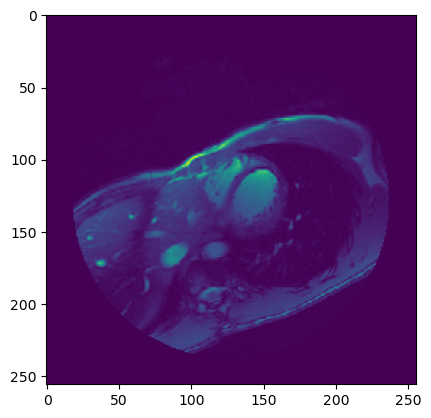

In [26]:
# print(Y_train[0][0])
plt.imshow(X_train[0])
plt.show()

In [27]:
kwargs = dict(
        rotation_range=180,
        zoom_range=0.0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True
    )

X_datagen = ImageDataGenerator(**kwargs)
Y_datagen = ImageDataGenerator(**kwargs)
val_X_datagen = ImageDataGenerator(**kwargs)
val_Y_datagen = ImageDataGenerator(**kwargs)


X_generator = X_datagen.flow(X_train, shuffle=False,
                                    batch_size=10, seed=seed)
Y_generator = Y_datagen.flow(Y_train, shuffle=False,
                                batch_size=10, seed=seed)
train_generator = zip(X_generator, Y_generator)

val_X_generator = val_X_datagen.flow(X_val, shuffle=False,
                                    batch_size=10, seed=seed)
val_Y_generator = val_Y_datagen.flow(Y_val, shuffle=False,
                                batch_size=10, seed=seed)
val_generator = zip(val_X_generator, val_Y_generator)

# Metricas

In [28]:
def dice_coef(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
    return dice

def dice_mon(smooth):
    def dicemon(y_true, y_pred):
        return dice_coef(y_true, y_pred, smooth=smooth)
    return dicemon

def jaccard_coef(y_true, y_pred, smooth=0.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jaccard = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return jaccard

def jaccard_mon(smooth):
    def jaccardmon(y_true, y_pred):
        return jaccard_coef(y_true, y_pred, smooth=smooth)
    return jaccardmon

# Modelando Unet

In [29]:
import tensorflow as tf
from keras.models import *
from keras.layers import *

tf.random.set_seed(seed)

In [30]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    
    # getting x to the same shape as the gating signal
    theta_x = Conv2D(inter_shape,(2,2), strides=(2,2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    
    # getting the gating signal to the same nunmber of filters as the inter_shape
    phi_g = Conv2D(inter_shape, (1,1), padding='same')(gating)
    
    upsample_g = Conv2DTranspose(inter_shape, (3,3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)
    
    concat_xg = add([upsample_g, theta_x])
    
    act_xg = Activation('relu')(concat_xg)
    
    psi = Conv2D(1, (1,1), padding='same')(act_xg)
    
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    
    y = multiply([upsample_psi, x])
    
    result = Conv2D(shape_x[3], (1,1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    
    return result_bn

In [31]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2D(512, (1, 1), padding='same')(c5)
u6 = Activation('relu')(u6)
u6 = attention_block(c4, u6, 512)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2D(512, (1, 1), padding='same')(c6)
u7 = Activation('relu')(u7)
u7 = attention_block(c3, u7, 256)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2D(512, (1, 1), padding='same')(c7)
u8 = Activation('relu')(u8)
u8 = attention_block(c2, u8, 128)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2D(512, (1, 1), padding='same')(c8)
u9 = Activation('relu')(u9)
u9 = attention_block(c1, u9, 64)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, 1, activation='sigmoid')(c9)
 
model = Model(inputs=[inputs], outputs=[outputs])

# Configurando as metricas
smooth = K.epsilon()
dice_model = dice_loss(smooth)
dicemon = dice_mon(smooth)
jaccardmon = jaccard_mon(smooth)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])
# model.compile(optimizer = 'adam', loss = dice_model, metrics = [dicemon, 'accuracy', jaccardmon])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_40[0][0]                  
____________________________________________________________________________________________

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH + '.h5', verbose=1, save_weights_only=True)

callbacks = [checkpoint,
#         tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_dicemon'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [ ]:
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=25, callbacks=callbacks)
results = model.fit(train_generator,steps_per_epoch=len(X_train)/10,epochs=100,
                    callbacks=callbacks, validation_data=val_generator, validation_steps=len(X_val)/10)
json_model = model.to_json()
open(MODEL_PATH + '.json', 'w').write(json_model)
model.save_weights(MODEL_PATH + '.h5', overwrite=True)

# save:
f = open(MODEL_PATH + '.pckl', 'wb')
pickle.dump(results.history, f)
f.close()

C:\Users\Margeo\anaconda3\envs\TCC\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
112/112 [==============================] - 106s 617ms/step - loss: 0.1319 - accuracy: 0.9646 - dicemon: 0.0557 - jaccardmon: 0.0292 - val_loss: 0.2161 - val_accuracy: 0.9742 - val_dicemon: 0.0760 - val_jaccardmon: 0.0401

Epoch 00001: saving model to modelo\Attention_da.h5
Epoch 2/100
112/112 [==============================] - 61s 543ms/step - loss: 0.0664 - accuracy: 0.9798 - dicemon: 0.0700 - jaccardmon: 0.0368 - val_loss: 0.1407 - val_accuracy: 0.9742 - val_dicemon: 0.0945 - val_jaccardmon: 0.0505

Epoch 00002: saving model to modelo\Attention_da.h5
Epoch 3/100
112/112 [==============================] - 61s 544ms/step - loss: 0.0652 - accuracy: 0.9798 - dicemon: 0.0744 - jaccardmon: 0.0393 - val_loss: 0.0927 - val_accuracy: 0.9742 - val_dicemon: 0.1031 - val_jaccardmon: 0.0554

Epoch 00003: saving model to modelo\Attention_da.h5
Epoch 4/100
112/112 [==============================] - 61s 545ms/step - loss: 0.0645 - accuracy: 0.9798 - dicemon: 0.0794 - jaccardmon: 0.0421 -


Epoch 00029: saving model to modelo\Attention_da.h5
Epoch 30/100
112/112 [==============================] - 61s 543ms/step - loss: 0.0240 - accuracy: 0.9878 - dicemon: 0.5563 - jaccardmon: 0.4160 - val_loss: 0.0281 - val_accuracy: 0.9818 - val_dicemon: 0.5711 - val_jaccardmon: 0.4327

Epoch 00030: saving model to modelo\Attention_da.h5
Epoch 31/100
112/112 [==============================] - 61s 543ms/step - loss: 0.0236 - accuracy: 0.9879 - dicemon: 0.5640 - jaccardmon: 0.4245 - val_loss: 0.0291 - val_accuracy: 0.9814 - val_dicemon: 0.5565 - val_jaccardmon: 0.4175

Epoch 00031: saving model to modelo\Attention_da.h5
Epoch 32/100
112/112 [==============================] - 61s 544ms/step - loss: 0.0230 - accuracy: 0.9882 - dicemon: 0.5682 - jaccardmon: 0.4282 - val_loss: 0.0286 - val_accuracy: 0.9816 - val_dicemon: 0.5733 - val_jaccardmon: 0.4343

Epoch 00032: saving model to modelo\Attention_da.h5
Epoch 33/100
112/112 [==============================] - 61s 544ms/step - loss: 0.0226 - a

112/112 [==============================] - 61s 543ms/step - loss: 0.0185 - accuracy: 0.9897 - dicemon: 0.6416 - jaccardmon: 0.5050 - val_loss: 0.0227 - val_accuracy: 0.9831 - val_dicemon: 0.6193 - val_jaccardmon: 0.4854

Epoch 00058: saving model to modelo\Attention_da.h5
Epoch 59/100
112/112 [==============================] - 61s 544ms/step - loss: 0.0183 - accuracy: 0.9897 - dicemon: 0.6463 - jaccardmon: 0.5099 - val_loss: 0.0235 - val_accuracy: 0.9834 - val_dicemon: 0.6296 - val_jaccardmon: 0.4964

Epoch 00059: saving model to modelo\Attention_da.h5
Epoch 60/100
112/112 [==============================] - 61s 543ms/step - loss: 0.0178 - accuracy: 0.9899 - dicemon: 0.6531 - jaccardmon: 0.5188 - val_loss: 0.0229 - val_accuracy: 0.9828 - val_dicemon: 0.6345 - val_jaccardmon: 0.5002

Epoch 00060: saving model to modelo\Attention_da.h5
Epoch 61/100
112/112 [==============================] - 61s 543ms/step - loss: 0.0182 - accuracy: 0.9898 - dicemon: 0.6468 - jaccardmon: 0.5112 - val_loss:

In [ ]:
# Carregar modelo
model = model_from_json(open(MODEL_PATH + '.json').read())
model.load_weights(MODEL_PATH + '.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])

# retrieve:    
f = open(MODEL_PATH + '.pckl', 'rb')
results = pickle.load(f)
f.close()

In [18]:
print(results.history.keys())
model.evaluate(X_train, Y_train)

dict_keys(['loss', 'accuracy', 'dicemon', 'jaccardmon', 'val_loss', 'val_accuracy', 'val_dicemon', 'val_jaccardmon'])
36/36 [==============================] - 22s 382ms/step - loss: 0.0577 - accuracy: 0.9785 - dicemon: 0.1722 - jaccardmon: 0.0973


[0.057682424783706665,
 0.9785370826721191,
 0.17224130034446716,
 0.09731642156839371]

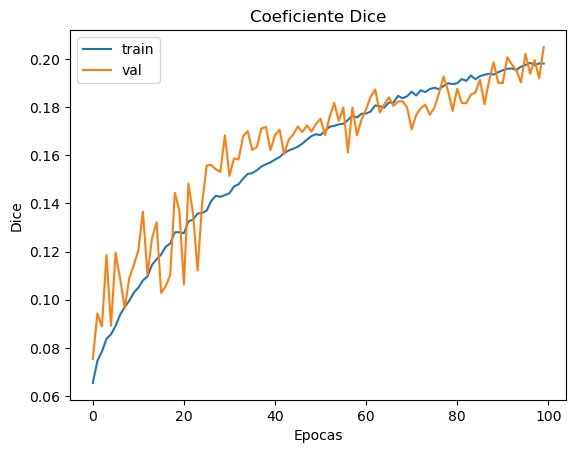

In [20]:
plt.plot(results.history['dicemon'])
plt.plot(results.history['val_dicemon'])
plt.title('Coeficiente Dice')

plt.ylabel('Dice')
plt.xlabel('Epocas')
plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
predict_test = model.predict(X_test, verbose=1)

6/6 [==============================] - 3s 385ms/step


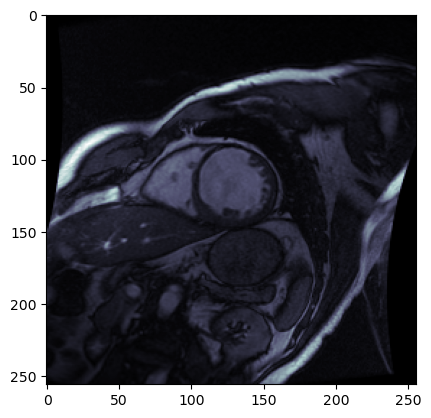

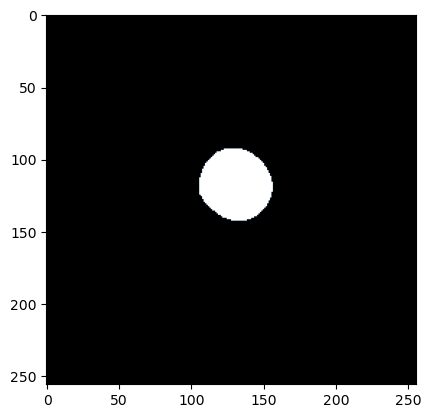

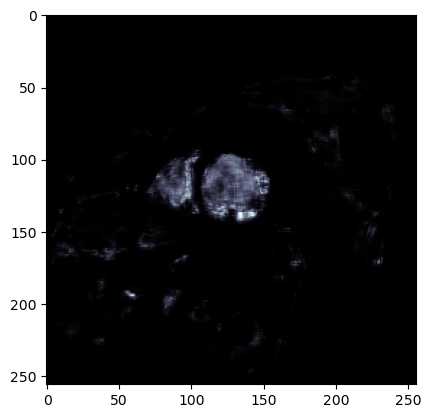

In [58]:
# Ver exemplos de imagens
exemplo = 27

plt.imshow(X_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(predict_test[exemplo], cmap=plt.cm.bone)
plt.show()

In [ ]:
from skimage import img_as_ubyte 

def add_mascara(imagem, mascara, cor):
    img = imagem.copy()
    if np.ndim(img) == 2:
        img2 = np.empty((256, 256, 3), dtype=img.dtype)
        img2[:,:,:] = img[:,:, np.newaxis]
        img = img2
    
    mask = mascara.copy()
    if np.ndim(mask) == 3:
#         mask = cv2.cvtColor(mask.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
#         ret, bw_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        bw_mask = mask
    else:
        bw_mask = img_as_ubyte(mask)
        
    contours, _ = cv2.findContours(bw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        ctrs = [len(ctr) for ctr in contours]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contours[max_ctr]])
        cv2.drawContours(img, np.array([pontos]),  0, cor, 1)

    return img
    

def marcar_ground_truth(ind, imagem, mascara):
    img1 = imagem[ind]
    img1 = np.squeeze(img1)
    img2 = mascara[ind]   
    img3 = add_mascara(img1, img2, (0, 255, 0))
    
    return img3

def marcar_predict(ind, imagem, mascara):
    img1 = imagem
    img2 = np.squeeze(mascara[ind])
    img3 = add_mascara(img1, img2, (255, 0, 0))
    return img3

dicom = X_test[exemplo]
mascara_gt = Y_test[exemplo]
mascara_p = predict_test[exemplo]

dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
plt.imshow(X_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_val[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_val[0], cmap=plt.cm.bone)
plt.show()